## Import Libraries

In [1]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.fftpack import fft
from datetime import datetime, timedelta

#Jlab Packages
from data_utils import get_traces
from beam_settings_parser_hdf5 import BeamConfigParserHDF5
from beam_settings_prep import BeamConfigPreProcessor


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

### BPM Config ###

In [2]:
class BPMDataConfig:

    def __init__(self):
        self.beam_settings_data_path = "/work/data_science/suf_sns/beam_configurations_data/processed_data/clean_beam_config_processed_df.csv"
        self.beam_param_parser_cfg = {"data_location": "/work/data_science/suf_sns/beam_configurations_data/hdf5_sept2024/"}
        self.beam_settings_prep_cfg = {
            "rescale": False,
            "beam_config": [
                'FE_IS:Match:TunerPos',
                'LEBT:Chop_N:V_Set',
                'LEBT:Chop_P:V_Set',
                'LEBT:Focus_1:V_Set',
                'LEBT:Focus_2:V_Set',
                'LEBT:Steer_A:V_Set',
                'LEBT:Steer_B:V_Set',
                'LEBT:Steer_C:V_Set',
                'LEBT:Steer_D:V_Set',
                'Src:Accel:V_Set',
                'Src:H2:Flw_Set',
                'Src:Ign:Pwr_Set',
                'Src:RF_Gnd:Pwr_Set',
                'ICS_Chop:RampDown:PW',
                'ICS_Chop:RampUp:PWChange',
                'ICS_MPS:Gate_Source:Offset',
                'ICS_Tim:Chop_Flavor1:BeamOn',
                'ICS_Tim:Chop_Flavor1:OnPulseWidth',
                'ICS_Tim:Chop_Flavor1:RampUp',
                'ICS_Tim:Chop_Flavor1:StartPulseWidth',
                'ICS_Tim:Gate_BeamRef:GateWidth',
                'ICS_Tim:Gate_BeamOn:RR'
            ]
        }
        self.beam_config = [
            'timestamps',
            'FE_IS:Match:TunerPos',
            'LEBT:Chop_N:V_Set',
            'LEBT:Chop_P:V_Set',
            'LEBT:Focus_1:V_Set',
            'LEBT:Focus_2:V_Set',
            'LEBT:Steer_A:V_Set',
            'LEBT:Steer_B:V_Set',
            'LEBT:Steer_C:V_Set',
            'LEBT:Steer_D:V_Set',
            'Src:Accel:V_Set',
            'Src:H2:Flw_Set',
            'Src:Ign:Pwr_Set',
            'Src:RF_Gnd:Pwr_Set',
            'ICS_Chop:RampDown:PW',
            'ICS_Chop:RampUp:PWChange',
            'ICS_MPS:Gate_Source:Offset',
            'ICS_Tim:Chop_Flavor1:BeamOn',
            'ICS_Tim:Chop_Flavor1:OnPulseWidth',
            'ICS_Tim:Chop_Flavor1:RampUp',
            'ICS_Tim:Chop_Flavor1:StartPulseWidth',
            'ICS_Tim:Gate_BeamRef:GateWidth',
            'ICS_Tim:Gate_BeamOn:RR'
        ]

        self.column_to_add = [
    'FE_IS:Match:TunerPos',
    'LEBT:Chop_N:V_Set',
    'LEBT:Chop_P:V_Set',
    'LEBT:Focus_1:V_Set',
    'LEBT:Focus_2:V_Set',
    'LEBT:Steer_A:V_Set',
    'LEBT:Steer_B:V_Set',
    'LEBT:Steer_C:V_Set',
    'LEBT:Steer_D:V_Set',
    'Src:Accel:V_Set',
    'Src:H2:Flw_Set',
    'Src:Ign:Pwr_Set',
    'Src:RF_Gnd:Pwr_Set',
    'ICS_Tim:Gate_BeamOn:RR',
    'ICS_Chop-RampDown-PW',
    'ICS_Chop-RampUp-PWChange',
    'ICS_Tim-Gate_BeamRef-GateWidth'
]

        self.rename_mappings = {
    'ICS_Chop-RampDown-PW': 'ICS_Chop:RampDown:PW',
    'ICS_Chop-RampUp-PWChange': 'ICS_Chop:RampUp:PWChange',
    'ICS_MPS-Gate_Source-Offset': 'ICS_MPS:Gate_Source:Offset',
    'ICS_Chop-BeamOn-Width': 'ICS_Tim:Chop_Flavor1:BeamOn',
    'ICS_Chop-BeamOn-PW': 'ICS_Tim:Chop_Flavor1:OnPulseWidth',
    'ICS_Chop-RampUp-Width': 'ICS_Tim:Chop_Flavor1:RampUp',
    'ICS_Chop-RampUp-PW': 'ICS_Tim:Chop_Flavor1:StartPulseWidth',
    'ICS_Tim-Gate_BeamRef-GateWidth': 'ICS_Tim:Gate_BeamRef:GateWidth'
}


    def configs_hist(self, dataframe, timestamp):
        subset_columns = dataframe.columns.tolist()
        subset_columns.remove(timestamp)
        df_shifted = dataframe[subset_columns].shift(1)
        mask = (dataframe[subset_columns] == df_shifted).all(axis=1)
        dataframe = dataframe[~mask]

        dataframe['time_diff'] = dataframe[timestamp].diff()
        dataframe['timestamps_trm'] = dataframe[timestamp] + dataframe['time_diff'].shift(-1) - timedelta(seconds=0.000001)

        subset_columns.insert(0, timestamp)
        subset_columns.insert(1, "timestamps_trm")

        return dataframe[subset_columns]

    def summary(self, text, df):
        print(f'{text} shape: {df.shape}')

        # Filter for numeric columns only
        numeric_cols = df.select_dtypes(include=['number'])

        summ = pd.DataFrame(numeric_cols.dtypes, columns=['dtypes'])
        summ['null'] = numeric_cols.isnull().sum()
        summ['unique'] = numeric_cols.nunique()
        summ['min'] = numeric_cols.min()
        summ['median'] = numeric_cols.median()
        summ['max'] = numeric_cols.max()
        summ['mean'] = numeric_cols.mean()
        summ['std'] = numeric_cols.std()
        summ['duplicate'] = df.duplicated().sum()

        return summ


    def update_beam_config(self,beam_config_df):
        for col in self.column_to_add:
            if col not in beam_config_df.columns:
                beam_config_df[col] = np.nan

        beam_config_df.rename(columns=self.rename_mappings, inplace=True)
        return beam_config_df


# Create an instance of BPMDataConfig
dc = BPMDataConfig()


In [3]:
beam_config_df = pd.read_csv(dc.beam_settings_data_path)
beam_config_df = beam_config_df.drop("Unnamed: 0", axis=1, errors='ignore')
beam_config_df['timestamps'] = pd.to_datetime(beam_config_df['timestamps'])


In [4]:
### Sep24 hdf5 beam settings ###
parser = BeamConfigParserHDF5(dc.beam_param_parser_cfg)
data, _ = parser.run()

Provided file is not hdf5 format, skipping:  .ipynb_checkpoints
BeamParamParser: Number of samples parsed
FE_IS:Match:TunerPos 633
ICS_Chop:RampDown:PW 41
ICS_Chop:RampUp:PWChange 869
ICS_MPS:Gate_Source:Offset 262
ICS_Tim:Chop_Flavor1:BeamOn 1780
ICS_Tim:Chop_Flavor1:OnPulseWidth 2564
ICS_Tim:Chop_Flavor1:RampUp 52
ICS_Tim:Chop_Flavor1:StartPulseWidth 16
ICS_Tim:Gate_BeamOn:RR 12437
ICS_Tim:Gate_BeamRef:GateWidth 1818
LEBT:Chop_N:V_Set 6557
LEBT:Chop_P:V_Set 6561
LEBT:Focus_1:V_Set 3018
LEBT:Focus_2:V_Set 3018
LEBT:Steer_A:V_Set 6550
LEBT:Steer_B:V_Set 6557
LEBT:Steer_C:V_Set 6554
LEBT:Steer_D:V_Set 6551
Src:Accel:V_Set 3408
Src:H2:Flw_Set 2959
Src:Ign:Pwr_Set 2942
Src:RF_Gnd:Pwr_Set 5


In [5]:
### Get Prepared datasets ###
prep = BeamConfigPreProcessor(dc.beam_settings_prep_cfg)
prepared_settings, run_cfg = prep.run(data)


['FE_IS:Match:TunerPos', 'LEBT:Chop_N:V_Set', 'LEBT:Chop_P:V_Set', 'LEBT:Focus_1:V_Set', 'LEBT:Focus_2:V_Set', 'LEBT:Steer_A:V_Set', 'LEBT:Steer_B:V_Set', 'LEBT:Steer_C:V_Set', 'LEBT:Steer_D:V_Set', 'Src:Accel:V_Set', 'Src:H2:Flw_Set', 'Src:Ign:Pwr_Set', 'Src:RF_Gnd:Pwr_Set', 'ICS_Chop:RampDown:PW', 'ICS_Chop:RampUp:PWChange', 'ICS_MPS:Gate_Source:Offset', 'ICS_Tim:Chop_Flavor1:BeamOn', 'ICS_Tim:Chop_Flavor1:OnPulseWidth', 'ICS_Tim:Chop_Flavor1:RampUp', 'ICS_Tim:Chop_Flavor1:StartPulseWidth', 'ICS_Tim:Gate_BeamRef:GateWidth', 'ICS_Tim:Gate_BeamOn:RR']
Length of beam param df:  48909


In [6]:
# Convert configs to list
beam_config_df = dc.update_beam_config(beam_config_df)
bpm = pd.concat([beam_config_df, prepared_settings])

In [7]:
dc.summary('bpm_summary', bpm)

bpm_summary shape: (67764, 23)


,dtypes,null,unique,min,median,max,mean,std,duplicate
ICS_Tim:Chop_Flavor1:BeamOn,float64,0,645,0.000000,886.000000,1000.000000,794.016616,256.706192,827
ICS_Tim:Chop_Flavor1:StartPulseWidth,float64,0,36,0.000000,18.000000,55.000000,18.404389,3.075782,827
ICS_Chop:RampUp:PWChange,float64,0,27,0.000000,4.000000,4095.000000,10.059028,97.181057,827
ICS_Chop:RampDown:PW,float64,0,16,0.000000,18.000000,45.000000,18.192654,1.649764,827
ICS_MPS:Gate_Source:Offset,float64,0,140,-949.967480,-20.000000,0.000000,-30.240840,77.447447,827
ICS_Tim:Chop_Flavor1:RampUp,float64,0,49,0.000000,98.000000,99.000000,90.025781,26.656475,827
ICS_Tim:Chop_Flavor1:OnPulseWidth,float64,0,39,0.000000,40.000000,55.000000,33.201124,11.371221,827
ICS_Tim:Gate_BeamRef:GateWidth,float64,0,664,0.000000,986.000000,1052.000000,825.438979,343.844063,827
FE_IS:Match:TunerPos,float32,18855,3,58.009998,58.040001,58.040001,58.035648,0.020661,827
LEBT:Chop_N:V_Set,float32,18855,2,2.430000,2.700000,2.700000,2.699995,0.001783,827


### DCM Configs

In [8]:
class DCMDatConfig:

    def __init__(self):
        self.dataset1_loc = "/work/data_science/suf_sns/DCM_Errant/"
        self.dataset2_loc = "/w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024"
        self.start_date = 20220218
        self.end_date = 20220318
        self.anomaly_type = "00110000"  # --  48
        self.length_of_waveform = 10000
        self.exclude_dates = [20220220, 20220221, 20220222, 20220223, 20220301, 20220308, 20220309, 20220315]  # Fixed date

        self.filtered_normal_files = []
        self.filtered_anomaly_files = []
        self.filtered_normal_files2 = []
        self.filtered_anomaly_files2 = []
        self.traces = []
        self.timestamps = []
        

    
    def GetSepFilteredFiles(self):
        subfolders = [f.path for f in os.scandir(self.dataset2_loc) if f.is_dir()]
        for directory in subfolders:
            if "normal" in directory or "anomal" in directory:
                for root, _, files in os.walk(directory):
                    for file in files:
                        if ".gz" in file:
                            if 'normal' in directory:
                                self.filtered_normal_files2.append(os.path.join(root, file))
                            elif "anomal" in directory:
                                self.filtered_anomaly_files2.append(os.path.join(root, file))

        print('Number of available normal files:', len(self.filtered_normal_files2))
        print('Number of available anomaly files:', len(self.filtered_anomaly_files2))
        return self.filtered_normal_files2, self.filtered_anomaly_files2

    def GetTracesAndTs(self,filtered_files):
        index = np.random.randint(0, len(filtered_files))
        filepath = filtered_files[index]
        print(index)
        try:
            self.traces, self.timestamps = get_traces(filepath, var_id="Trace2", begin=3000, shift=self.length_of_waveform, data_type=0)
        except Exception as e:
            print("Error in reading the file: ", filepath)
            print("Error:", e)
        return self.traces, self.timestamps
        

dcm = DCMDatConfig()


In [9]:
### Print Sep Data Details ###
filtered_normal_files_sep,filtered_anomaly_files_sep=dcm.GetSepFilteredFiles()

Number of available normal files: 10699
Number of available anomaly files: 20592


## Get Traces and Timestamps 

In [10]:
traces_norm,timestamps_norm=dcm.GetTracesAndTs(filtered_normal_files_sep)

8948


In [11]:
traces_anorm,timestamps_anorm=dcm.GetTracesAndTs(filtered_anomaly_files_sep)

11033
Non zero alarm value (48) in a named normal file at:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/mnt/pool0/Instruments/DCML/autostream/2024_09/23_16/20240923_162359.2187_DCML.bin.gz
Next timestamp is 0:00:00.099995 sec apart


## Merge Datasets

In [12]:
class MergeDatasets:
    
    def __init__(self):
        self.length_of_waveform = 10000
    
    def process_files(self,file_list, label, flag_value, data_type, alarm=None):
        traces, timestamps, flag, file = [], [], [], []

        for dcml in file_list[:20]:
            if alarm is not None:
                tmp_trace, tmp_timestamp = get_traces(
                dcml, var_id="Trace2", begin=3000, shift=self.length_of_waveform, data_type=data_type, alarm=alarm
            )
            else:
                tmp_trace, tmp_timestamp = get_traces(
                dcml, var_id="Trace1", begin=3000, shift=self.length_of_waveform, data_type=data_type
            )

            if not tmp_trace or not tmp_timestamp:
                print(f"Skipping {dcml} due to empty trace/timestamp")
                continue

            tmp_trace = np.array(tmp_trace)
            tmp_timestamp = np.array(tmp_timestamp)

            if len(tmp_trace) > 1:
                tmp_trace = tmp_trace[1:]
            if len(tmp_timestamp) > 1:
                tmp_timestamp = tmp_timestamp[1:]

            traces.extend(tmp_trace.tolist())
            flag.extend([flag_value] * len(tmp_trace))
            file.extend([label] * len(tmp_trace))
            timestamps.extend(tmp_timestamp.tolist())

        return pd.DataFrame({
        'anomoly_flag': flag,
        'file': file,
        'timestamps': timestamps,
        'traces': traces
    })


md = MergeDatasets()

In [13]:
# Process all datasets
dcm_Sep24_N = md.process_files(file_list=filtered_normal_files_sep, label='Sep24', flag_value=0, data_type=0)

In [14]:
dcm_Sep24_A = md.process_files(file_list=filtered_anomaly_files_sep,label="Sep24", flag_value=1, data_type=-1,alarm=48)

File:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_183444.5928_DCML.bin.gz   bWidth below threshold: 52
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_183444.5928_DCML.bin.gz due to empty trace/timestamp


/scratch/slurm/42299698/.cache/tmp/ipykernel_2298637/2665616354.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not tmp_trace or not tmp_timestamp:


Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_185817.2886_DCML.bin.gz due to empty trace/timestamp
File:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_182423.6166_DCML.bin.gz   bWidth below threshold: 30
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_182423.6166_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_153409.4191_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_151450.1136_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_152410.2755_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_153652.7629_DCML.bin.gz due to empty trace/timestamp
S

In [15]:
# Combine all into one DataFrame
dcm=pd.concat([dcm_Sep24_N, dcm_Sep24_A], ignore_index=True)

In [16]:
merged_df = pd.merge_asof(
    dcm.sort_values("timestamps"), 
    bpm.sort_values("timestamps"), 
    on="timestamps", 
    direction="nearest"
)
merged_df.columns

Index(['anomoly_flag', 'file', 'timestamps', 'traces',
       'ICS_Tim:Chop_Flavor1:BeamOn', 'ICS_Tim:Chop_Flavor1:StartPulseWidth',
       'ICS_Chop:RampUp:PWChange', 'ICS_Chop:RampDown:PW',
       'ICS_MPS:Gate_Source:Offset', 'ICS_Tim:Chop_Flavor1:RampUp',
       'ICS_Tim:Chop_Flavor1:OnPulseWidth', 'ICS_Tim:Gate_BeamRef:GateWidth',
       'FE_IS:Match:TunerPos', 'LEBT:Chop_N:V_Set', 'LEBT:Chop_P:V_Set',
       'LEBT:Focus_1:V_Set', 'LEBT:Focus_2:V_Set', 'LEBT:Steer_A:V_Set',
       'LEBT:Steer_B:V_Set', 'LEBT:Steer_C:V_Set', 'LEBT:Steer_D:V_Set',
       'Src:Accel:V_Set', 'Src:H2:Flw_Set', 'Src:Ign:Pwr_Set',
       'Src:RF_Gnd:Pwr_Set', 'ICS_Tim:Gate_BeamOn:RR'],
      dtype='object')

In [17]:
merged_df.head()

,anomoly_flag,file,timestamps,traces,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,LEBT:Chop_P:V_Set,LEBT:Focus_1:V_Set,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,2024-09-01 15:05:05.036102,"[-0.000244140625, -0.0005371093866415322, -0.0...",908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,2024-09-01 15:14:51.180287,"[-0.0005859375232830644, -0.000390625005820766...",908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,2024-09-01 15:23:58.859281,"[9.765625145519152e-05, -0.0002929687616415322...",908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,2024-09-01 15:31:43.174806,"[0.0003906250058207661, 0.0002929687616415322,...",908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,2024-09-01 15:37:38.527843,"[-0.0003417968691792339, 0.0005859375232830644...",908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


## Data Preprocessing

In [18]:
class DataPreprocessor:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def check_nan(self):
        nan_counts = self.df.isna().sum()
        return nan_counts[nan_counts > 0]

    def remove_nan(self):
        self.df.dropna(inplace=True)
        return self.df

    def check_duplicates(self):
        df_copy = self.df.applymap(lambda x: tuple(x) if isinstance(x, np.ndarray) else x)
        return df_copy.duplicated().sum()


    def remove_duplicates(self):
        self.df.drop_duplicates(inplace=True)
        return self.df

    def check_outliers(self):
        outlier_dict = {}
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = self.df[(self.df[col] < (Q1 - 1.5 * IQR)) | (self.df[col] > (Q3 + 1.5 * IQR))].shape[0]
            if outliers > 0:
                outlier_dict[col] = outliers
        return outlier_dict

    def remove_outliers(self):
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
        return self.df

    def convert_float64_to_float32(self):
        float64_cols = self.df.select_dtypes(include=['float64']).columns
        self.df[float64_cols] = self.df[float64_cols].astype('float32')
        return self.df

    def rename_columns(self, rename_dict):
        self.df.rename(columns=rename_dict, inplace=True)
        return self.df

    def get_dataframe(self):
        return self.df


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   anomoly_flag                          1188 non-null   int64         
 1   file                                  1188 non-null   object        
 2   timestamps                            1188 non-null   datetime64[ns]
 3   traces                                1188 non-null   object        
 4   ICS_Tim:Chop_Flavor1:BeamOn           1188 non-null   float64       
 5   ICS_Tim:Chop_Flavor1:StartPulseWidth  1188 non-null   float64       
 6   ICS_Chop:RampUp:PWChange              1188 non-null   float64       
 7   ICS_Chop:RampDown:PW                  1188 non-null   float64       
 8   ICS_MPS:Gate_Source:Offset            1188 non-null   float64       
 9   ICS_Tim:Chop_Flavor1:RampUp           1188 non-null   float64       
 10  

In [20]:
processed_df=merged_df[merged_df.columns[~merged_df.columns.isin(['timestamps','traces'])]]
processed_df.head()

,anomoly_flag,file,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,LEBT:Chop_P:V_Set,LEBT:Focus_1:V_Set,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


In [21]:
processed_df['anomoly_flag'].value_counts()

anomoly_flag
0    1180
1       8
Name: count, dtype: int64

In [22]:
preprocessor = DataPreprocessor(processed_df)
print("NaN values before removal:\n", preprocessor.check_nan())
preprocessor.remove_nan()
print("Duplicate rows before removal:", preprocessor.check_duplicates())
#preprocessor.remove_duplicates()
#print("Outliers before removal:\n", preprocessor.check_outliers())
#preprocessor.remove_outliers()
preprocessor.convert_float64_to_float32()
cleaned_df = preprocessor.get_dataframe()

cleaned_df.head()

NaN values before removal:
 Series([], dtype: int64)
Duplicate rows before removal: 1182


,anomoly_flag,file,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,LEBT:Chop_P:V_Set,LEBT:Focus_1:V_Set,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


In [23]:
cleaned_df['traces']=merged_df['traces']
cleaned_df['timestamps']=merged_df['timestamps']
cleaned_df.drop(columns=['file','anomoly_flag'],inplace=True,axis=1)
cleaned_df.head()

,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,LEBT:Chop_P:V_Set,LEBT:Focus_1:V_Set,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR,traces,timestamps
0,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.000244140625, -0.0005371093866415322, -0.0...",2024-09-01 15:05:05.036102
1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.0005859375232830644, -0.000390625005820766...",2024-09-01 15:14:51.180287
2,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[9.765625145519152e-05, -0.0002929687616415322...",2024-09-01 15:23:58.859281
3,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[0.0003906250058207661, 0.0002929687616415322,...",2024-09-01 15:31:43.174806
4,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,2.7,46.0,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.0003417968691792339, 0.0005859375232830644...",2024-09-01 15:37:38.527843


In [25]:
# Convert 'timestamps' to numeric features
cleaned_df["timestamp_seconds"] = pd.to_datetime(cleaned_df["timestamps"], errors="coerce").astype(int) / 10**9
cleaned_df["time_diff"] = cleaned_df["timestamp_seconds"].diff().fillna(0)

In [26]:
# Convert 'traces' from string format to numerical lists
cleaned_df["traces"] = cleaned_df["traces"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

In [27]:
# Handle 10K-Dimensional Traces
def extract_trace_features(trace_row):
    """Extracts key statistical features from a single trace row."""
    downsampled_trace = trace_row[::20]  # Reduce from 10,000 to 500 points
    mean_val = np.mean(downsampled_trace)
    std_val = np.std(downsampled_trace)
    peak_val = np.max(downsampled_trace)
    fft_val = np.abs(fft(downsampled_trace)[1])  # First FFT component
    return np.hstack([downsampled_trace[:50], mean_val, std_val, peak_val, fft_val]) 

In [28]:
# Extract features from all traces
trace_features = np.array(cleaned_df["traces"].apply(extract_trace_features).tolist())

In [30]:
# Reduce dimensionality using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
trace_features_pca = pca.fit_transform(trace_features)

In [31]:
# Merge PCA-reduced traces with dataframe
trace_feature_names = [f"PCA_Trace_{i}" for i in range(trace_features_pca.shape[1])]
df_pca = pd.DataFrame(trace_features_pca, columns=trace_feature_names)
df = pd.concat([cleaned_df.drop(columns=["traces"], errors="ignore"), df_pca], axis=1)

In [66]:
# Sampling function for latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [67]:
# Sequential Inputs for VAE-BiLSTM 
window_size = 100  # Use last 100 time steps
latent_dim = 16  # Size of VAE latent space

In [68]:
# Extract rolling sequences for pulse traces and time-based features
X_train_combined = []
for i in range(window_size, len(df)):
    past_pulses = df.iloc[i - window_size:i][trace_feature_names + ["time_diff"]]
    X_train_combined.append(past_pulses.values)

# X_train_combined = np.array(X_train_combined)  # Convert to NumPy array
X_train_combined = np.array(X_train_combined, dtype=np.float32)
X_train_combined = np.nan_to_num(X_train_combined)

In [81]:
# Build VAE-BiLSTM Model 
class MyVAE(Model):
    def __init__(self, window_size, num_features, latent_dim=16):
        super(MyVAE, self).__init__()
        self.window_size = window_size
        self.num_features = num_features
        self.latent_dim = latent_dim

        # --- Encoder Layers ---
        self.encoder_bilstm_1 = Bidirectional(LSTM(64, return_sequences=True))
        self.encoder_bilstm_2 = Bidirectional(LSTM(32, return_sequences=False))
        self.z_mean_dense = Dense(latent_dim, name="z_mean")
        self.z_log_var_dense = Dense(latent_dim, name="z_log_var")

        # --- Decoder Layers ---
        self.repeat_vector = RepeatVector(window_size)
        self.decoder_bilstm_1 = Bidirectional(LSTM(32, return_sequences=True))
        self.decoder_bilstm_2 = Bidirectional(LSTM(64, return_sequences=True))
        self.output_dense = TimeDistributed(Dense(num_features))

    def encode(self, x):
        x = self.encoder_bilstm_1(x)
        x = self.encoder_bilstm_2(x)
        z_mean = self.z_mean_dense(x)
        z_log_var = self.z_log_var_dense(x)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    def decode(self, z):
        x = self.repeat_vector(z)
        x = self.decoder_bilstm_1(x)
        x = self.decoder_bilstm_2(x)
        return self.output_dense(x)

    def call(self, inputs):
        # 1) Encode
        z_mean, z_log_var = self.encode(inputs)
        # 2) Sample z
        z = self.reparameterize(z_mean, z_log_var)
        # 3) Decode
        x_recon = self.decode(z)

        # --- Compute KL Divergence ---
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=-1
        )
        # Add KL loss to the model
        self.add_loss(kl_loss)

        return x_recon


In [86]:
window_size = 100
num_features = 51
vae_model = MyVAE(window_size=window_size, num_features=num_features, latent_dim=16)

In [87]:
vae_model.compile(optimizer='adam', loss='mse')

In [88]:
vae_model.fit(X_train_combined, X_train_combined, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 2454408.2500 - val_loss: 18.7384
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 3448207.7500 - val_loss: 20.1356
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 2176524.2500 - val_loss: 21.0942
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 3427843.7500 - val_loss: 21.9133
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 2403779.0000 - val_loss: 24.9977
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 2579631.2500 - val_loss: 23.2192
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 1904498.3750 - val_loss: 23.2301
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 2845425.5000 - val_loss: 23.0580
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 4179973.0000 - val_loss: 24.1159
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 2670368.2500 - val_loss: 22.7075
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 3641815

In [89]:
# Anomaly Detection 
# Compute reconstruction error for each pulse
X_pred_combined = vae.predict(X_train_combined)
reconstruction_errors = np.mean(np.abs(X_train_combined - X_pred_combined), axis=(1, 2))  # Mean absolute error

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [90]:
# Define anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

In [91]:
# Store anomaly results
df_anomalies_combined = pd.DataFrame({
    "Timestamp": df["timestamps"].iloc[window_size:],  # Align with pulse times
    "Reconstruction_Error": reconstruction_errors,
    "Anomaly": anomalies
})

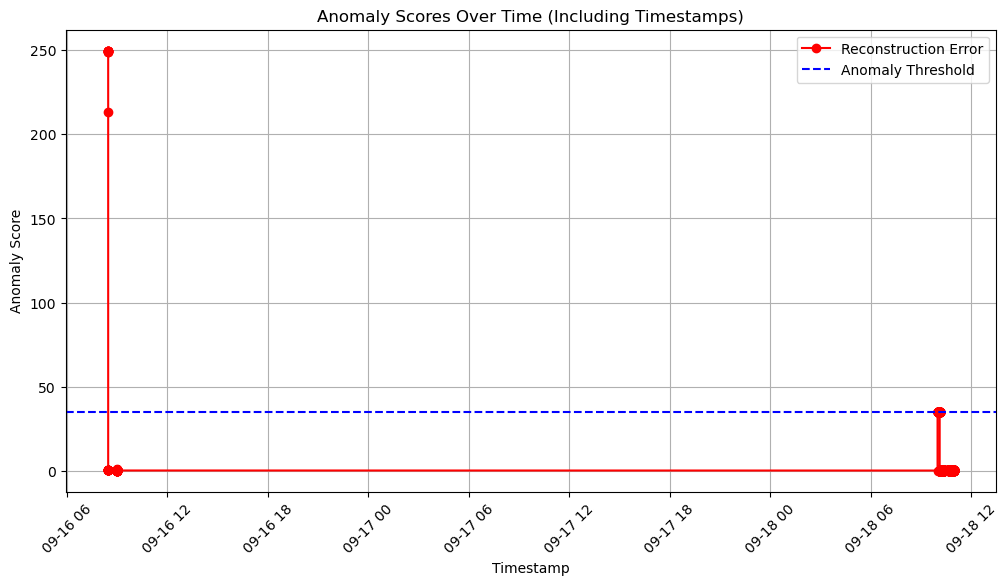

In [92]:
# Time-series plot of anomaly scores
plt.figure(figsize=(12, 6))
plt.plot(df_anomalies_combined["Timestamp"], df_anomalies_combined["Reconstruction_Error"], marker='o', linestyle='-', color='r', label="Reconstruction Error")
plt.axhline(threshold, color='blue', linestyle='dashed', label="Anomaly Threshold")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores Over Time (Including Timestamps)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

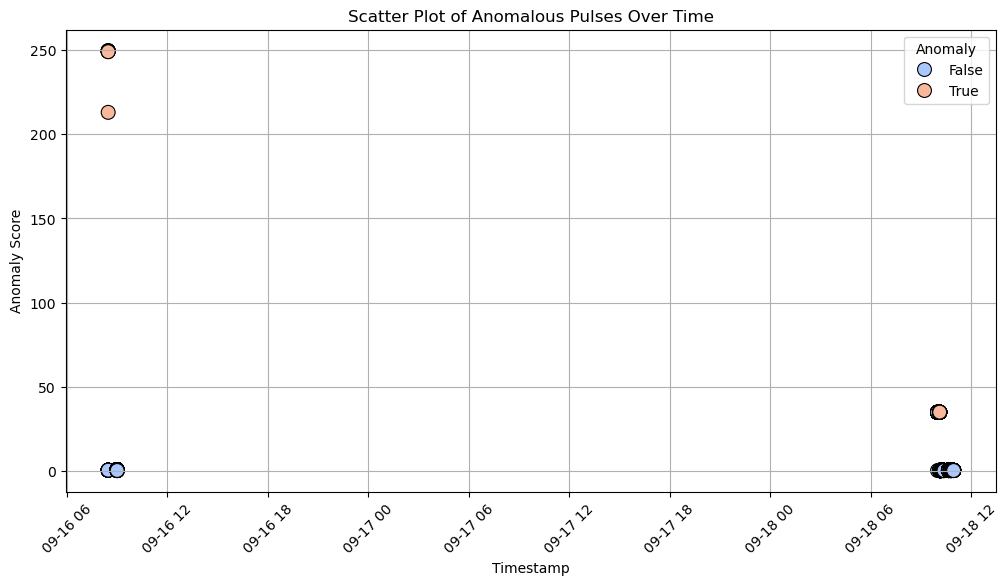

In [93]:
# Scatter Plot: Anomaly Score vs. Timestamp
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_anomalies_combined["Timestamp"], y=df_anomalies_combined["Reconstruction_Error"], hue=df_anomalies_combined["Anomaly"], palette="coolwarm", s=100, edgecolor="k")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Scatter Plot of Anomalous Pulses Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [94]:
# Display top anomalies
print("Top 20 Anomalous Pulses:")
print(df_anomalies_combined.sort_values(by="Reconstruction_Error", ascending=False).head(20))

Top 20 Anomalous Pulses:
                     Timestamp  Reconstruction_Error  Anomaly
100 2024-09-16 08:27:35.411245            249.664536     True
101 2024-09-16 08:27:35.511240            249.656219     True
102 2024-09-16 08:27:35.611237            249.487381     True
103 2024-09-16 08:27:35.711233            249.392715     True
104 2024-09-16 08:27:35.811230            249.349854     True
105 2024-09-16 08:27:35.911226            249.229904     True
106 2024-09-16 08:27:36.011222            249.094391     True
107 2024-09-16 08:27:36.111217            249.022797     True
108 2024-09-16 08:27:36.211214            212.996918     True
304 2024-09-18 10:07:39.386824             34.886505     True
312 2024-09-18 10:07:39.520152             34.881222     True
344 2024-09-18 10:07:40.053465             34.877155     True
315 2024-09-18 10:07:39.570150             34.874844     True
328 2024-09-18 10:07:39.786808             34.872314     True
334 2024-09-18 10:07:39.886805             34